# Modeling (baseline + NN) & Inference

## Setup & load

In [52]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

ROOT = Path("..").resolve()
DATA = ROOT/"data"
FIGS = ROOT/"reports/figures"
FIGS.mkdir(parents=True, exist_ok=True)
def savefig(fig, name): 
    path = FIGS/f"{name}.png"; fig.savefig(path, dpi=300, bbox_inches="tight"); print("Saved:", path)

def read_data(path: Path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        first = f.readline()
    skip = 1 if first.lower().startswith("data derived") else 0
    return pd.read_csv(path, low_memory=False, skiprows=skip)

train = read_data(DATA/"training_loan_data.csv")
test  = read_data(DATA/"testing_loan_data.csv")
target_col = next((c for c in train.columns if c.strip().lower()=="bad_flag"), None)
assert target_col
drop_cols = [c for c in ["id","member_id"] if c in train.columns]
train.shape, test.shape, target_col


((199121, 23), (102505, 23), 'bad_flag')

## Logistic Regression baseline (preprocessing + ROC figure)

/Users/manikmalhotra/Desktop/anaconda/anaconda3/envs/jpm/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation AUC (LR): 0.7033
              precision    recall  f1-score   support

           0      0.931     1.000     0.964     35266
           1      0.667     0.002     0.003      2626

    accuracy                          0.931     37892
   macro avg      0.799     0.501     0.484     37892
weighted avg      0.912     0.931     0.898     37892

Saved: /Users/manikmalhotra/jpm_quant_project/reports/figures/roc_logistic_baseline.png


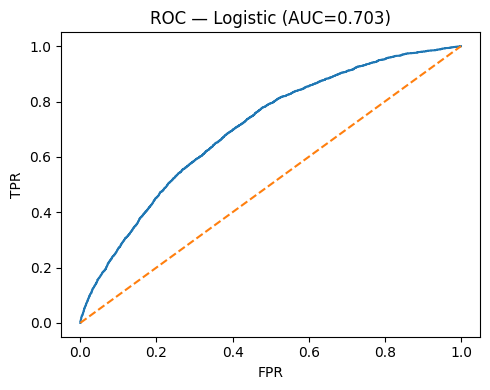

In [53]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, classification_report

y_raw = pd.to_numeric(train[target_col], errors="coerce")
mask = y_raw.notna()
y = y_raw.loc[mask].astype(int)
X = train.loc[mask].drop(columns=drop_cols + [target_col])

cat_cols = [c for c in X if X[c].dtype == "object"]
num_cols = [c for c in X if c not in cat_cols]

pre = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                      ("sc",  StandardScaler(with_mean=False))]), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("oh",  OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
])

X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf = Pipeline([("pre", pre), ("lr", LogisticRegression(max_iter=400))]).fit(X_tr, y_tr)

va_probs = clf.predict_proba(X_va)[:,1]
va_auc  = roc_auc_score(y_va, va_probs)
print("Validation AUC (LR):", round(va_auc,4))
print(classification_report(y_va, (va_probs>=0.5).astype(int), digits=3))

# ROC
fpr, tpr, _ = roc_curve(y_va, va_probs)
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(fpr, tpr); ax.plot([0,1],[0,1], linestyle="--")
ax.set_xlabel("FPR"); ax.set_ylabel("TPR"); ax.set_title(f"ROC — Logistic (AUC={va_auc:.3f})")
plt.tight_layout(); savefig(fig, "roc_logistic_baseline")


## PyTorch NN + ROC

Epoch 01 | train_loss=0.2665 | val_auc=0.6962
Epoch 02 | train_loss=0.2362 | val_auc=0.7098
Epoch 03 | train_loss=0.2335 | val_auc=0.7106
Epoch 04 | train_loss=0.2325 | val_auc=0.7083
Epoch 05 | train_loss=0.2312 | val_auc=0.7072
Epoch 06 | train_loss=0.2297 | val_auc=0.7062
Early stopping.
Best NN AUC: 0.7106
Saved: /Users/manikmalhotra/jpm_quant_project/reports/figures/roc_nn_mlp.png


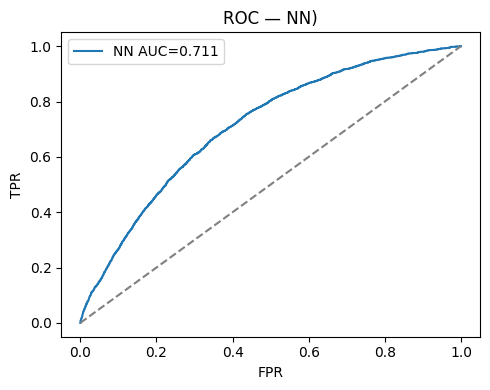

In [54]:
# NN: Compact MLP on OHE features
import numpy as np, scipy.sparse as sp, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1) Preprocessing for NN: group rare categories to keep OHE dimensions manageable
class RareCategoryGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, min_count=10, replacement="__RARE__"):
        self.min_count=int(min_count); self.replacement=replacement
        self.keep_maps_=None; self.n_features_=None
    def _to_array(self, X):
        import pandas as pd
        if hasattr(X, "values"):  # pandas DataFrame/Series
            return X.values
        return np.asarray(X)
    def fit(self, X, y=None):
        import pandas as pd
        X_arr=self._to_array(X)
        if X_arr.ndim==1: X_arr=X_arr.reshape(-1,1)
        self.n_features_=X_arr.shape[1]; self.keep_maps_=[]
        for j in range(self.n_features_):
            col=pd.Series(X_arr[:,j], copy=False)
            vc=col.value_counts(dropna=False)
            self.keep_maps_.append(set(vc[vc>=self.min_count].index.tolist()))
        return self
    def transform(self, X):
        import pandas as pd
        X_arr=self._to_array(X)
        if X_arr.ndim==1: X_arr=X_arr.reshape(-1,1)
        out=X_arr.astype(object, copy=True)
        for j, keep in enumerate(self.keep_maps_):
            col=pd.Series(out[:,j], copy=False)
            mask=col.isin(keep).to_numpy()
            tmp=out[:,j]
            tmp[~mask]=self.replacement
            out[:,j]=tmp
        return out

cat_small = Pipeline([
    ("imp",  SimpleImputer(strategy="most_frequent")),
    ("rare", RareCategoryGrouper(min_count=10, replacement="__RARE__")),
    ("oh",   OneHotEncoder(handle_unknown="ignore", sparse_output=True)),  # sklearn>=1.3
])
num_small = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc",  StandardScaler(with_mean=False)),  # plays nice with sparse stacking
])
pre_small = ColumnTransformer([
    ("num", num_small, num_cols),
    ("cat", cat_small, cat_cols),
])

# Fit on training split only to avoid leakage; transform train/val
X_tr_any = pre_small.fit_transform(X_tr)
X_va_any = pre_small.transform(X_va)
X_tr_sparse = X_tr_any.tocsr() if sp.issparse(X_tr_any) else sp.csr_matrix(X_tr_any)
X_va_sparse = X_va_any.tocsr() if sp.issparse(X_va_any) else sp.csr_matrix(X_va_any)

y_tr_np = y_tr.values.astype(np.float32)
y_va_np = y_va.values.astype(np.float32)

# 2) DataLoader that avoids dtype issues via a custom collate_fn
class SparseBatchDS(Dataset):
    def __init__(self, X_csr, y):
        self.X = X_csr
        self.y = y
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i):
        # return numpy arrays; collate_fn will make tensors
        return self.X[i].toarray().astype(np.float32).ravel(), np.float32(self.y[i])

def collate_float32(batch):
    xs, ys = zip(*batch)                          # tuples of arrays/scalars
    xs = np.stack(xs).astype(np.float32)          # (B, F)
    ys = np.asarray(ys, dtype=np.float32)         # (B,)
    return torch.from_numpy(xs), torch.from_numpy(ys)

BATCH = 256
train_loader = DataLoader(SparseBatchDS(X_tr_sparse, y_tr_np),
                          batch_size=BATCH, shuffle=True, num_workers=0,
                          collate_fn=collate_float32)
val_loader   = DataLoader(SparseBatchDS(X_va_sparse, y_va_np),
                          batch_size=BATCH, shuffle=False, num_workers=0,
                          collate_fn=collate_float32)

# 3) Model: small MLP
class MLP(nn.Module):
    def __init__(self, in_dim, hidden=128, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden, hidden//2), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden//2, 1)
        )
    def forward(self, x): return self.net(x).squeeze(-1)

device = torch.device("cpu")  # CPU is fine for tabular MLP
in_dim = X_tr_sparse.shape[1]
model  = MLP(in_dim).to(device)
opt    = torch.optim.AdamW(model.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss()

# 4) Train with early stopping on AUC
def eval_auc(loader):
    model.eval(); logits_all=[]; y_all=[]
    with torch.no_grad():
        for xb,yb in loader:
            xb = xb.to(device)           # tensors already
            logits_all.append(model(xb).cpu().numpy())
            y_all.append(yb.cpu().numpy())
    probs = 1/(1+np.exp(-np.concatenate(logits_all)))
    ytrue = np.concatenate(y_all)
    return roc_auc_score(ytrue, probs), probs

best_auc, bad_epochs, patience = -1.0, 0, 3
for epoch in range(20):
    model.train(); tot=0.0; n=0
    for xb,yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward(); opt.step()
        tot += loss.item()*xb.size(0); n += xb.size(0)
    tr_loss = tot / max(1,n)
    va_auc, _ = eval_auc(val_loader)
    print(f"Epoch {epoch+1:02d} | train_loss={tr_loss:.4f} | val_auc={va_auc:.4f}")
    if va_auc > best_auc + 1e-4:
        best_auc, bad_epochs = va_auc, 0
        best_state = {k: v.cpu().clone() for k,v in model.state_dict().items()}
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print("Early stopping."); break

# restore best
if 'best_state' in locals():
    model.load_state_dict(best_state)
print("Best NN AUC:", round(best_auc, 4))

# 5) ROC curve for NN
_, va_probs_nn = eval_auc(val_loader)
fpr, tpr, _ = roc_curve(y_va_np, va_probs_nn)
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(fpr, tpr, label=f"NN AUC={best_auc:.3f}")
ax.plot([0,1],[0,1], linestyle="--", color="gray")
ax.set_xlabel("FPR"); ax.set_ylabel("TPR"); ax.set_title("ROC — NN)")
ax.legend()
plt.tight_layout(); savefig(fig, "roc_nn_mlp")



Model comparison figure (LR vs NN)

Saved: /Users/manikmalhotra/jpm_quant_project/reports/figures/roc_comparison_lr_vs_nn.png


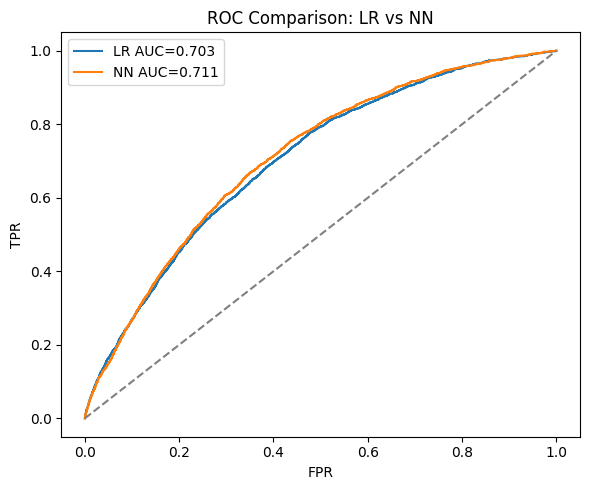

In [55]:
# Compare ROC curves on the same axes
from sklearn.metrics import roc_curve, roc_auc_score

# LR probs already computed: va_probs
# NN probs: va_probs_nn
auc_lr = roc_auc_score(y_va, va_probs)
auc_nn = roc_auc_score(y_va, va_probs_nn)

fig, ax = plt.subplots(figsize=(6,5))
fpr_lr, tpr_lr, _ = roc_curve(y_va, va_probs)
fpr_nn, tpr_nn, _ = roc_curve(y_va, va_probs_nn)
ax.plot(fpr_lr, tpr_lr, label=f"LR AUC={auc_lr:.3f}")
ax.plot(fpr_nn, tpr_nn, label=f"NN AUC={auc_nn:.3f}")
ax.plot([0,1],[0,1], linestyle="--", color="gray")
ax.set_xlabel("FPR"); ax.set_ylabel("TPR"); ax.set_title("ROC Comparison: LR vs NN")
ax.legend()
plt.tight_layout(); savefig(fig, "roc_comparison_lr_vs_nn")


## Inference → prediction for LR

In [56]:
import os
os.makedirs("../outputs", exist_ok=True)

# Predict on test set using LR with tuned threshold
X_test = test.drop(columns=[c for c in drop_cols if c in test.columns])
test_probs_lr = full_clf.predict_proba(X_test)[:, 1]

threshold_lr = best_threshold if "best_threshold" in locals() else 0.5
test_preds_lr = (test_probs_lr >= threshold_lr).astype(int)

id_col = "id" if "id" in test.columns else test.columns[0]
out_lr = pd.DataFrame({id_col: test[id_col], "bad_flag": test_preds_lr})

# Save predictions
lr_path = "../outputs/test_predictions.csv"
out_lr.to_csv(lr_path, index=False)
print(f"Saved LR predictions: {lr_path} | Shape: {out_lr.shape}")


Saved LR predictions: ../outputs/test_predictions.csv | Shape: (102505, 2)


## Inference → prediction for NN

In [57]:
X_test_any = pre_small.transform(X_test)
X_test_sparse = sp.csr_matrix(X_test_any) if not sp.issparse(X_test_any) else X_test_any.tocsr()

model.eval()
logits_t = []
for i in range(0, X_test_sparse.shape[0], 256):
    xb = X_test_sparse[i:i+256].toarray().astype(np.float32)
    with torch.no_grad():
        logits_t.append(model(torch.tensor(xb, device=device)).cpu().numpy())

test_probs_nn = 1 / (1 + np.exp(-np.concatenate(logits_t).ravel()))

threshold_nn = best_threshold_nn if "best_threshold_nn" in locals() else 0.5
test_preds_nn = (test_probs_nn >= threshold_nn).astype(int)

out_nn = pd.DataFrame({id_col: test[id_col], "bad_flag": test_preds_nn})

# Save predictions
nn_path = "../outputs/test_predictions_nn.csv"
out_nn.to_csv(nn_path, index=False)
print(f"Saved NN predictions: {nn_path} | Shape: {out_nn.shape}")


Saved NN predictions: ../outputs/test_predictions_nn.csv | Shape: (102505, 2)


In [58]:
# Analyses to check whether bad_flag is 1 or not
print("LR Probability Stats:", test_probs_lr.min(), test_probs_lr.max(), test_probs_lr.mean())
print("LR Pred Counts:", np.unique(test_preds_lr, return_counts=True))

print("NN Probability Stats:", test_probs_nn.min(), test_probs_nn.max(), test_probs_nn.mean())
print("NN Pred Counts:", np.unique(test_preds_nn, return_counts=True))

df = pd.read_csv("../outputs/test_predictions.csv")  # or test_predictions_nn.csv
count_1 = (df["bad_flag"] == 1).sum()
count_0 = (df["bad_flag"] == 0).sum()

print(f"0's: {count_0}, 1's: {count_1}")


df = pd.read_csv("../outputs/test_predictions.csv")  # or test_predictions_nn.csv
ids_with_1 = df.loc[df["bad_flag"] == 1, "id"]  # change "id" if your column name is different

print("IDs with bad_flag = 1:")
print(ids_with_1.tolist())  # as a Python list


ids_with_1.to_csv("../outputs/ids_with_bad_flag_1.csv", index=False)
print("Saved to ../outputs/ids_with_bad_flag_1.csv")
print("Output file: test_predictions.csv")

LR Probability Stats: 2.1386773612196775e-19 0.6986779303981525 0.05796608426285391
LR Pred Counts: (array([0, 1]), array([102486,     19]))
NN Probability Stats: 4.710882e-19 0.3941232 0.072096474
NN Pred Counts: (array([0]), array([102505]))
0's: 102486, 1's: 19
IDs with bad_flag = 1:
[20033912, 20034430, 20037663, 20042136, 20044684, 20048481, 20050568, 20052370, 20053897, 20061146, 20061810, 20062231, 20063403, 20063764, 20065005, 20067585, 20068783, 20077099, 20078794]
Saved to ../outputs/ids_with_bad_flag_1.csv
Output file: test_predictions.csv
